<a href="https://colab.research.google.com/github/mukkatharun/advance-deep-learning-assignments/blob/main/assignment2_GraphNeuralNetworks/Node_classification_using_Graph_Convolutional_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Install required packages

In [ ]:
pip install stellargraph

Importing the required libraries

In [27]:
import pandas as pd
import os

import stellargraph as sg
from stellargraph.mapper import FullBatchNodeGenerator
from stellargraph.layer import GCN

from tensorflow.keras import layers, optimizers, losses, metrics, Model
from sklearn import preprocessing, model_selection
from IPython.display import display, HTML
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
dataset = sg.datasets.Cora()
display(HTML(dataset.description))
G, node_subjects = dataset.load()

In [5]:
node_subjects.value_counts().to_frame()

,subject
Neural_Networks,818
Probabilistic_Methods,426
Genetic_Algorithms,418
Theory,351
Case_Based,298
Reinforcement_Learning,217
Rule_Learning,180


Data Splitting

In [6]:
train_subjects, test_subjects = model_selection.train_test_split(
    node_subjects, train_size=140, test_size=None, stratify=node_subjects
)
val_subjects, test_subjects = model_selection.train_test_split(
    test_subjects, train_size=500, test_size=None, stratify=test_subjects
)

In [7]:
train_subjects.value_counts().to_frame()

,subject
Neural_Networks,42
Probabilistic_Methods,22
Genetic_Algorithms,22
Theory,18
Case_Based,16
Reinforcement_Learning,11
Rule_Learning,9


Converting to numeric arrays

In [8]:
target_encoding = preprocessing.LabelBinarizer()

train_targets = target_encoding.fit_transform(train_subjects)
val_targets = target_encoding.transform(val_subjects)
test_targets = target_encoding.transform(test_subjects)

GCN layers creation

In [9]:
generator = FullBatchNodeGenerator(G, method="gcn")

Using GCN (local pooling) filters...


In [10]:
train_gen = generator.flow(train_subjects.index, train_targets)

In [11]:
gcn = GCN(
    layer_sizes=[16, 16], activations=["relu", "relu"], generator=generator, dropout=0.5
)

In [12]:
x_inp, x_out = gcn.in_out_tensors()

x_out

<KerasTensor: shape=(1, None, 16) dtype=float32 (created by layer 'gather_indices')>

In [13]:
predictions = layers.Dense(units=train_targets.shape[1], activation="softmax")(x_out)

Modelling

In [14]:
model = Model(inputs=x_inp, outputs=predictions)
model.compile(
    optimizer=optimizers.Adam(lr=0.01),
    loss=losses.categorical_crossentropy,
    metrics=["acc"],
)

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [15]:
val_gen = generator.flow(val_subjects.index, val_targets)

In [16]:
from tensorflow.keras.callbacks import EarlyStopping

es_callback = EarlyStopping(monitor="val_acc", patience=50, restore_best_weights=True)

In [17]:
history = model.fit(
    train_gen,
    epochs=100,
    validation_data=val_gen,
    verbose=2,
    shuffle=False,  # this should be False, since shuffling data means shuffling the whole graph
    callbacks=[es_callback],
)

Epoch 1/200
1/1 - 2s - loss: 1.9310 - acc: 0.2214 - val_loss: 1.8695 - val_acc: 0.3240 - 2s/epoch - 2s/step
Epoch 2/200
1/1 - 0s - loss: 1.8613 - acc: 0.3000 - val_loss: 1.7927 - val_acc: 0.3020 - 120ms/epoch - 120ms/step
Epoch 3/200
1/1 - 0s - loss: 1.7624 - acc: 0.3143 - val_loss: 1.7282 - val_acc: 0.3020 - 114ms/epoch - 114ms/step
Epoch 4/200
1/1 - 0s - loss: 1.6837 - acc: 0.3071 - val_loss: 1.6769 - val_acc: 0.3020 - 120ms/epoch - 120ms/step
Epoch 5/200
1/1 - 0s - loss: 1.6103 - acc: 0.3071 - val_loss: 1.6236 - val_acc: 0.3060 - 127ms/epoch - 127ms/step
Epoch 6/200
1/1 - 0s - loss: 1.5198 - acc: 0.3071 - val_loss: 1.5573 - val_acc: 0.3140 - 125ms/epoch - 125ms/step
Epoch 7/200
1/1 - 0s - loss: 1.4361 - acc: 0.3714 - val_loss: 1.4857 - val_acc: 0.3720 - 122ms/epoch - 122ms/step
Epoch 8/200
1/1 - 0s - loss: 1.3594 - acc: 0.4500 - val_loss: 1.4154 - val_acc: 0.4400 - 129ms/epoch - 129ms/step
Epoch 9/200
1/1 - 0s - loss: 1.2621 - acc: 0.5500 - val_loss: 1.3550 - val_acc: 0.4920 - 150ms

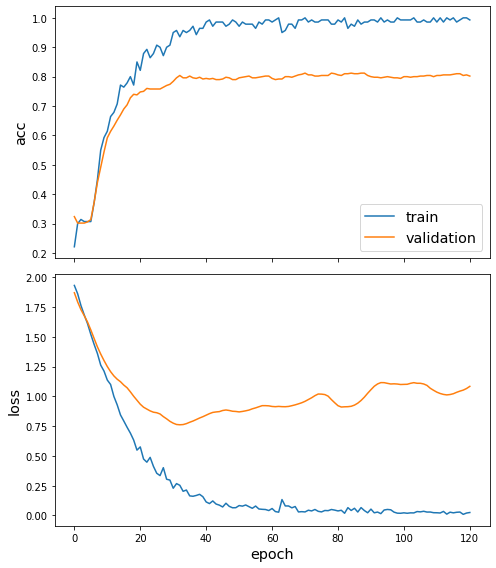

In [18]:
sg.utils.plot_history(history)

Calculting Test Metrics

In [19]:
test_gen = generator.flow(test_subjects.index, test_targets)

In [20]:
test_metrics = model.evaluate(test_gen)
print("\nTest Set Metrics:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

1/1 [==============================] - 0s 74ms/step - loss: 0.9623 - acc: 0.7935

Test Set Metrics:
	loss: 0.9623
	acc: 0.7935


Predictions

In [21]:
all_nodes = node_subjects.index
all_gen = generator.flow(all_nodes)
all_predictions = model.predict(all_gen)

1/1 [==============================] - 0s 187ms/step


In [22]:
node_predictions = target_encoding.inverse_transform(all_predictions.squeeze())

In [23]:
df = pd.DataFrame({"Predicted": node_predictions, "True": node_subjects})
df.head(20)

,Predicted,True
31336,Neural_Networks,Neural_Networks
1061127,Rule_Learning,Rule_Learning
1106406,Reinforcement_Learning,Reinforcement_Learning
13195,Reinforcement_Learning,Reinforcement_Learning
37879,Probabilistic_Methods,Probabilistic_Methods
1126012,Probabilistic_Methods,Probabilistic_Methods
1107140,Reinforcement_Learning,Theory
1102850,Neural_Networks,Neural_Networks
31349,Neural_Networks,Neural_Networks
1106418,Theory,Theory


Node embeddings

In [24]:
embedding_model = Model(inputs=x_inp, outputs=x_out)

In [25]:
emb = embedding_model.predict(all_gen)
emb.shape

1/1 [==============================] - 0s 117ms/step


(1, 2708, 16)

Dimensional Reduction

In [28]:
transform = TSNE  # or PCA

In [29]:
X = emb.squeeze(0)
X.shape

(2708, 16)

In [30]:
trans = transform(n_components=2)
X_reduced = trans.fit_transform(X)
X_reduced.shape

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


(2708, 2)

[Text(0, 0.5, '$X_2$'),
 Text(0.5, 0, '$X_1$'),
 Text(0.5, 1.0, 'TSNE visualization of GCN embeddings for cora dataset'),
 None]

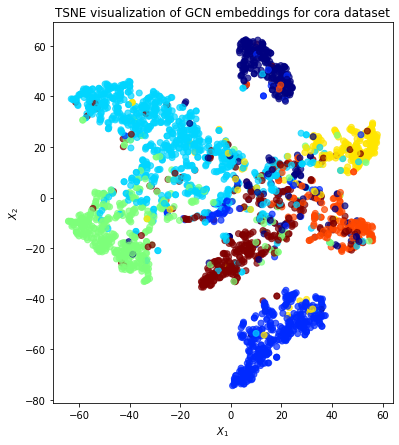

In [31]:
fig, ax = plt.subplots(figsize=(7, 7))
ax.scatter(
    X_reduced[:, 0],
    X_reduced[:, 1],
    c=node_subjects.astype("category").cat.codes,
    cmap="jet",
    alpha=0.7,
)
ax.set(
    aspect="equal",
    xlabel="$X_1$",
    ylabel="$X_2$",
    title=f"{transform.__name__} visualization of GCN embeddings for cora dataset",
)